In [1]:
import pandas as pd
import seaborn as sb

In [2]:
sb.set(rc={'figure.figsize':(20,15)}, style="darkgrid")

In [29]:
full_set = pd.DataFrame()
full_set["multi_agent_set1"] = pd.read_json("./hp_search_results/set1_results.json").T[0].rolling(window=100).mean()
full_set["multi_agent_set10"] = pd.read_json("./hp_search_results/set10_results.json").T[0].rolling(window=100).mean()
full_set["multi_agent_set11"] = pd.read_json("./hp_search_results/set11_results.json").T[0].rolling(window=100).mean()
full_set["single_agent_set1"] = pd.read_json("./hp_v1_search_results/set1_results.json").T[0].rolling(window=100).mean()

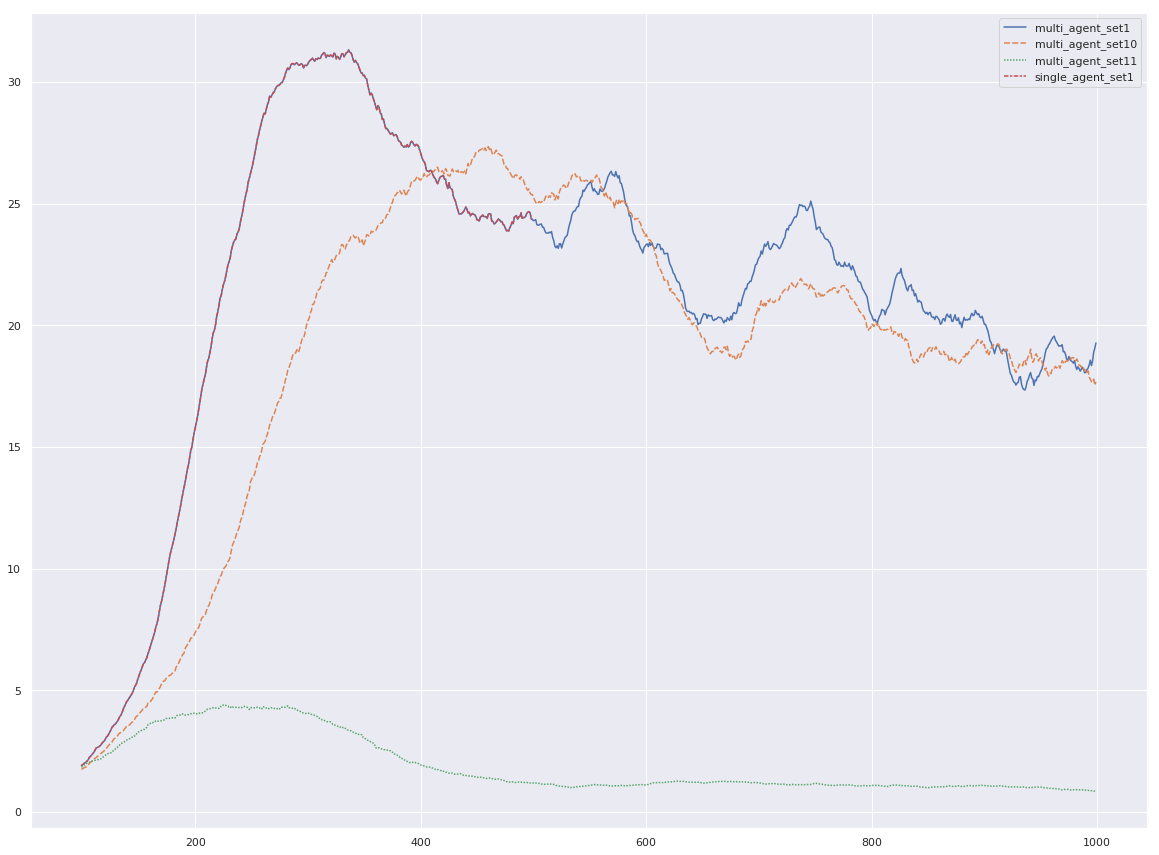

In [30]:
sb.lineplot(data = full_set)

In [25]:
full_set

,single_agent_set1,multi_agent_set1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN
